In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterVector

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import optimizer to optimize the variational cirucit
from qiskit.aqua.components.optimizers import COBYLA

from qiskit import Aer

from qiskit.providers.aer import StatevectorSimulator


In [3]:
provider = IBMQ.load_account()

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()


## Make the compressed XYZ gate a variational gate

In [12]:
# This is the compressed variational XYZ gate
def R_xyz_variational(theta):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*theta-np.pi/2, 0)
    t_qc.rz(2 * theta, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [13]:
theta = ParameterVector('theta', 5)

In [14]:
# We use "randomization", i.e. change the order of the sum over qubits at every Trotter layer
# we see that this way the same gate with the same angle is repeated, we can thus combine the gates with double the variational parameter

num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

Trot_qc.append(R_xyz_variational(theta[0]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz_variational(2 * theta[1]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz_variational(2 * theta[2]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz_variational(2 * theta[3]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz_variational(theta[4]).to_instruction(), [Trot_qr[1], Trot_qr[2]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

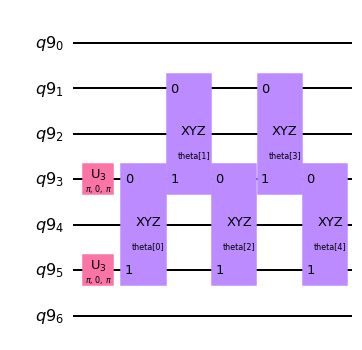

In [15]:
# The final time of the state evolution
# target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
## Standard and alternative 1

#for _ in range(trotter_steps):
#    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
## Alternative 2
qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#qc = qc.bind_parameters({t: target_time/trotter_steps})

qc.decompose().draw(output="mpl")  # view decomposition of trotter gates

In [134]:
def get_var_form(theta):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    # qc.x([3,5])
    qc.rx(np.pi, [3, 5])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    Trot_qc.append(R_xyz_variational(theta[0]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(2 * theta[1]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(2 * theta[2]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(2 * theta[3]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(theta[4]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    # qc.measure(qr, [qr[1], qr[3], qr[5]])
    return qc, qr

In [136]:
def objective_function(params):

    # TODO: Put Stefano's algorithm here

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    # qc.x([3,5])
    qc.rx(np.pi, [3, 5])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc, _ = get_var_form(theta)
    qc = qc.bind_parameters({theta: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [137]:
# Optimize the circuit parameters
optimizer = COBYLA(maxiter=500, tol=0.0001)
#params = np.random.rand(5)
#params = np.zeros(5)

params = (np.pi/4)*np.ones(5)
ret = optimizer.optimize(num_vars=5, objective_function=objective_function, initial_point=params)

In [138]:
ret

(array([1.78539816, 0.78534191, 0.78539816, 0.78531549, 0.80102316]),
 3.088263577089023e-07,
 54)

In [139]:
# Check fidelity using full state tomography
qc, qr = get_var_form(theta)
qc = qc.bind_parameters({theta: ret[0]})
#qc = qc.bind_parameters({theta2: np.zeros(5)})
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

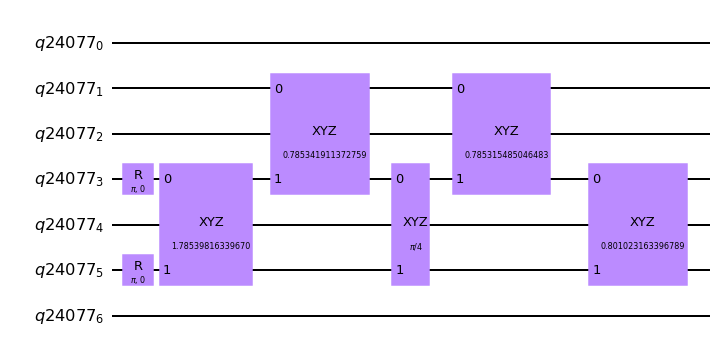

In [140]:
qc.decompose().draw(output="mpl") 

In [141]:
shots = 8192
reps = 1
backend = sim_noisy_jakarta
# backend = Aer.get_backend('aer_simulator_statevector')
# reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID c9d270f9-e8f9-4d6a-816f-909c92ae04e5


In [142]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7716 ± 0.0000


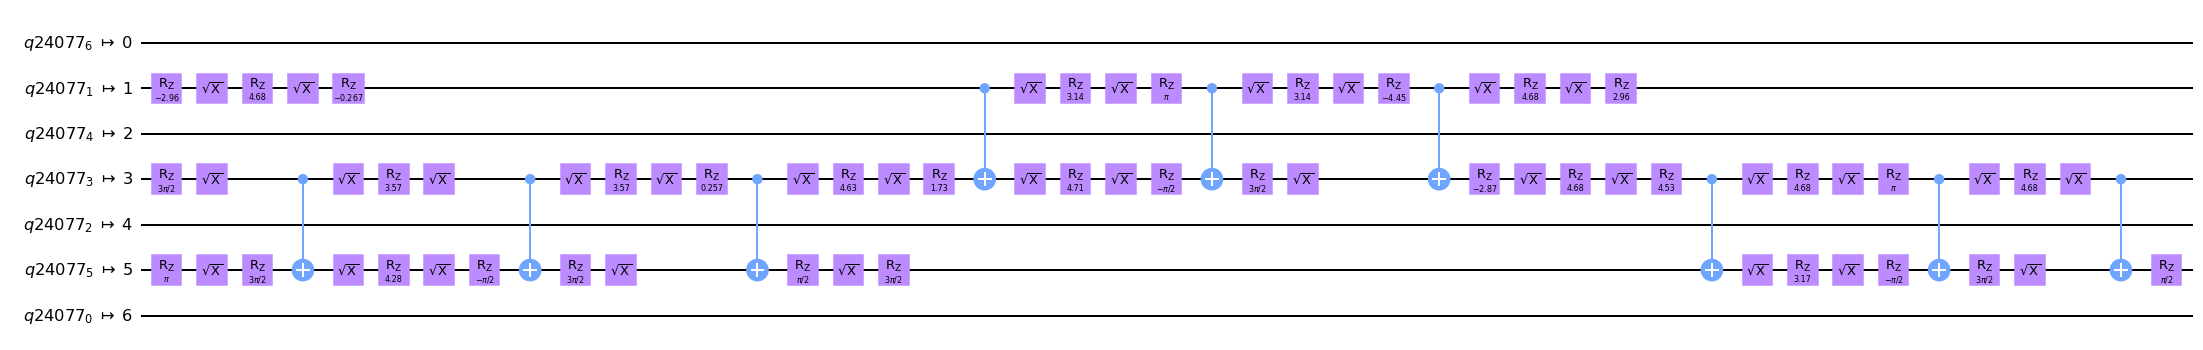

In [143]:
transpiled_qc = transpile(qc, optimization_level=3, backend=jakarta)
transpiled_qc.draw(output="mpl",fold=-1)

In [144]:
print('depth: {}, #cx: {}, #sx: {}'.format(transpiled_qc.depth(), transpiled_qc.count_ops()['cx'], transpiled_qc.count_ops()['sx']))

depth: 45, #cx: 9, #sx: 32


## Let's become ambitous and play around with error mitigation!

In [145]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory
from mitiq.zne.zne import execute_with_zne

In [166]:
# Function that does state tomography with circ and return the fideltiy
# To be used in the error mitigation (mitq)
def executor(circ):
    
    # Setting all the parameters that are need
    shots = 8192
    backend = sim_noisy_jakarta
    
    # Create list of state tomography circuits out of circ
    st_qcs = state_tomography_circuits(circ, [qr[1], qr[3], qr[5]])

    # Execute the state tomography circuits (maybe wrap into separate function)
    reps = 1
    jobs = []
    for _ in range(reps):

        job = execute(st_qcs, backend, optimization_level=3, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    # Compute tomography fidelities for each repetition (maybe wrap into separate function)
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
    
    return np.mean(fids)

In [175]:
executor(qc.decompose().decompose())

Job ID d1bbd8c4-c6bf-4adf-8b63-00409d0f0104


0.7574512638519403

In [168]:
# method: scale noise by 1 and 2, then extrapolate linearly to the zero noise limit.
linear_fac = LinearFactory(scale_factors=[1.0, 2.0])

# method: scale noise by 1, 2 and 3, then evaluate the Richardson extrapolation.
richardson_fac = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])

# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)

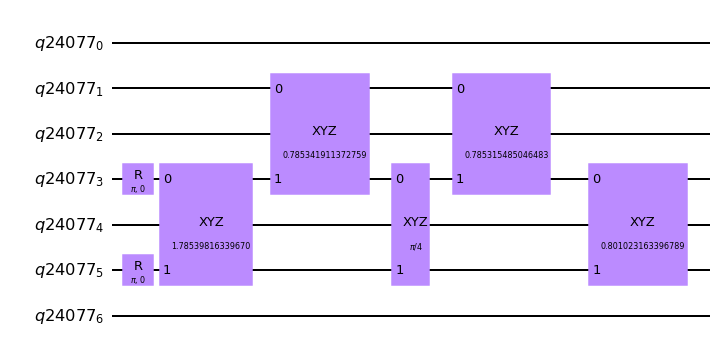

In [169]:
qc.decompose().draw(output="mpl",fold=-1)

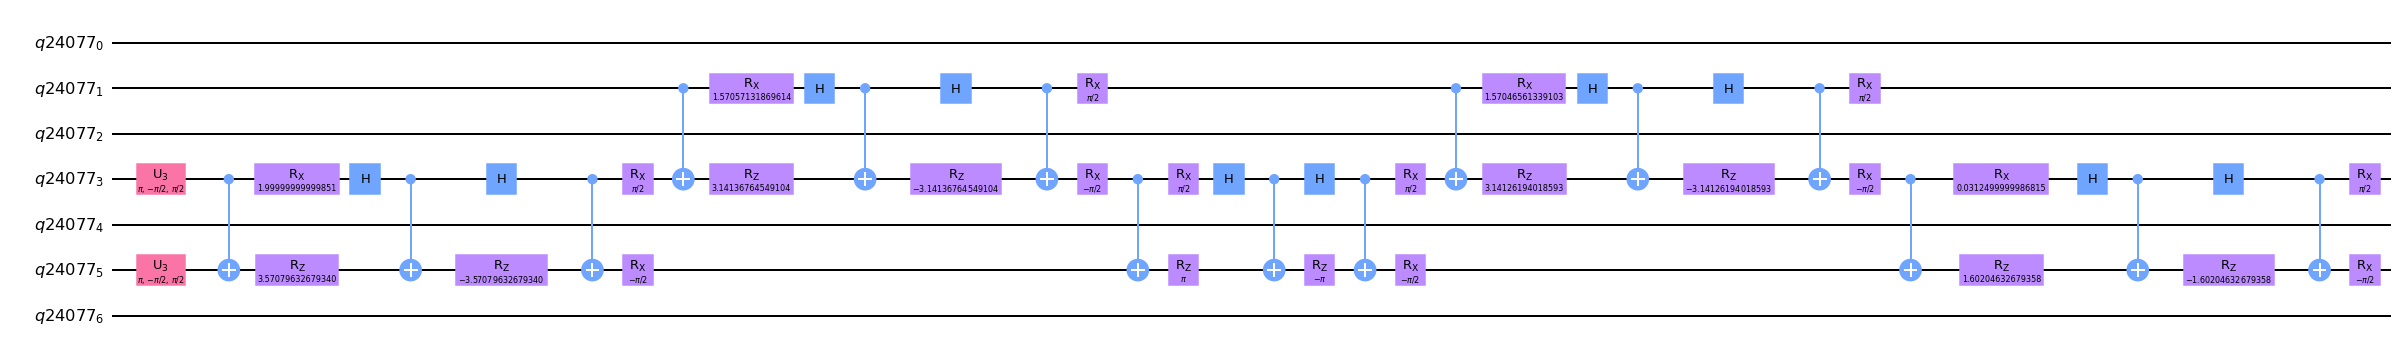

In [170]:
qc.decompose().decompose().draw(output="mpl",fold=-1)

In [172]:
#zne_expval = execute_with_zne(qc.decompose().decompose(), executor, factory=linear_fac)
#print(f"Error with linear_fac: {abs(1 - zne_expval):.4f}")

#zne_expval = execute_with_zne(qc, objective_function, factory=richardson_fac)
#print(f"Error with richardson_fac: {abs(1 - zne_expval):.4f}")

zne_expval = execute_with_zne(qc.decompose().decompose(), executor, factory=poly_fac)
print(f"Error with poly_fac: {abs(1 - zne_expval):.4f}")

Job ID ef99922c-66f3-4f28-93c7-d6be42c3695d
Job ID 2401070c-5308-4001-9e03-e6f08ad1437f
Job ID de7f52a9-c6bb-41fa-bf8f-3e956687bba6
Job ID c1e0e05f-9490-4a19-84b4-b2a054f1575c
Error with poly_fac: 1.0001


In [176]:
zne_expval

-5.838221146509695e-05